In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler,FunctionTransformer,OneHotEncoder # For encoding categorical variables it doesnt matter if they are ordinal or not
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", message=".*glibc.*")

import time


/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
# Load Data
data = pd.read_csv('../datasets/heart.csv')
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [3]:
# Distingushing numerical and categorical features and train test split

categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing pipelines for both numerical and categorical data

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])


In [4]:
preprocessor.fit(X_train)

# Get feature names after one-hot encoding
ohe_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, ohe_feature_names])

# Hyperparameter grid for RandomizedSearchCV
param_distributions = { 
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.2, 0.3],
    'classifier__reg_alpha': [0, 0.01, 0.1, 1],
    'classifier__reg_lambda': [1, 1.5, 2, 3]
}

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=skf,
    verbose=0,
    n_jobs=-1,
    random_state=42
)



In [5]:
# Run Hyperparameter Tuning

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
print(f"Hyperparameter tuning took {end_time - start_time:.2f} seconds")
print("Best Hyperparameters:", random_search.best_params_)
best_model = random_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2

Hyperparameter tuning took 4.24 seconds
Best Hyperparameters: {'classifier__subsample': 0.8, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 1.0}
Accuracy: 0.8967391304347826
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88        82
           1       0.90      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184

Confusion Matrix:
 [[72 10]
 [ 9 93]]
ROC AUC Score: 0.9227642276422765


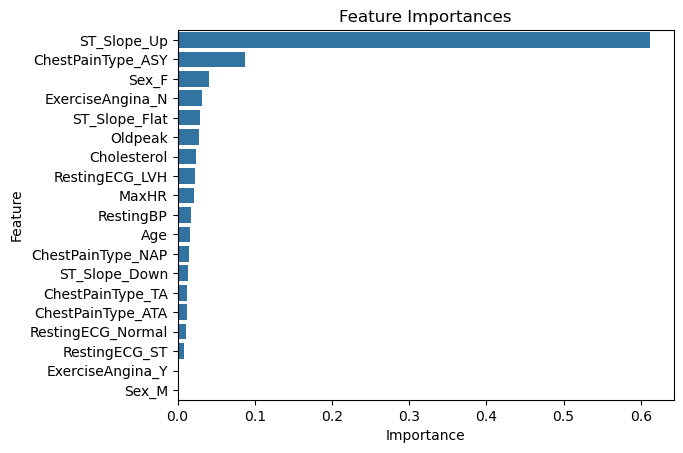

In [6]:
# Plot Feature importance
feature_importances = best_model.named_steps['classifier'].feature_importances_
feature_names = all_feature_names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

In [7]:
# Feature Engineering based on feature importance
# (This part can be expanded based on specific insights from feature importance)

threshold = 0.005
to_drop =  importance_df[importance_df['Importance'] < threshold]['Feature'].tolist()
print("Features to drop based on importance threshold:", to_drop)

def drop_low_importance_features(X):
    X_dropped = pd.DataFrame(X, columns=all_feature_names).copy()
    X_dropped = X_dropped.drop(columns=to_drop, errors='ignore')
    return X_dropped 

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', FunctionTransformer(drop_low_importance_features)),
    ('classifier', XGBClassifier(random_state=42))
])


Features to drop based on importance threshold: ['ExerciseAngina_Y', 'Sex_M']


In [8]:
# Hyperparameter tuning with RandomizedSearchCV (after feature engineering) 
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=skf,
    verbose=0,
    n_jobs=-1,
    random_state=42
)

# Fit the model
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()  
print(f"RandomizedSearchCV took {end_time - start_time:.2f} seconds to complete.")  
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the model (after feature engineering)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]) 

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print(f"ROC AUC Score: {roc_auc:.4f}")



RandomizedSearchCV took 1.15 seconds to complete.
Best Hyperparameters: {'classifier__subsample': 1.0, 'classifier__reg_lambda': 2, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.6}
Accuracy: 0.8967
Confusion Matrix:
[[71 11]
 [ 8 94]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        82
           1       0.90      0.92      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184

ROC AUC Score: 0.9236


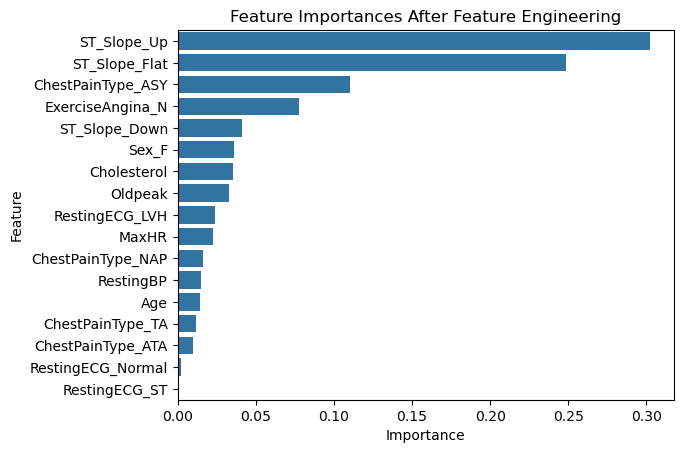

In [9]:
# Feature importance (after feature engineering)

feature_importances = best_model.named_steps['classifier'].feature_importances_
feature_names = [f for f in all_feature_names if f not in to_drop]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot Feature importance
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances After Feature Engineering')
plt.show()
 
